In [1]:
import pandas as pd
import numpy as np
import os
import json
from calculate_ppda import calculate_match_ppda

## 프리미어리그 분석

In [2]:
DATA_DIR = os.path.join("../", 'data', 'wyscout_data')
league = 'England'
matches_dir = os.path.join(DATA_DIR, 'refined_events', league)

In [3]:
match_files = [f for f in os.listdir(matches_dir) if f.endswith('.pkl')]
print(f"{league}: {len(match_files)}")

England: 380


In [4]:
# 모든 경기에 대해 PPDA를 계산하고 결과를 리스트에 저장
all_ppda_records = []
detail_ppda_records = []

for match_file in match_files:
	match_file_path = os.path.join(matches_dir, match_file)
	match_events = pd.read_pickle(match_file_path)

	# PPDA 값 계산
	ppda_values = calculate_match_ppda(match_events)

	team_ids = list(ppda_values.keys())
	home_team_id, away_team_id = team_ids[0], team_ids[1]

	home_team_name = match_events[match_events['team_id'] == home_team_id]['team_name'].iloc[0]
	away_team_name = match_events[match_events['team_id'] == away_team_id]['team_name'].iloc[0]
	home_ppda = ppda_values[home_team_id]
	away_ppda = ppda_values[away_team_id]

	detail_ppda_records.append({
		'home_team_id': home_team_id,
		'home_team_name': home_team_name,
		'home_ppda': home_ppda,
		'away_team_id': away_team_id,
		'away_team_name': away_team_name,
		'away_ppda': away_ppda
	})

	all_ppda_records.append({
		'team_id': home_team_id,
		'team_name': home_team_name,
		'ppda': home_ppda
	})
	all_ppda_records.append({
		'team_id': away_team_id,
		'team_name': away_team_name,
		'ppda': away_ppda
	})

# 데이터프레임 변환
ppda_df = pd.DataFrame(all_ppda_records)
detail_ppda_df = pd.DataFrame(detail_ppda_records)

In [5]:
# 팀별로 그룹화하여 평균 PPDA 계산
team_avg_ppda = ppda_df.dropna(subset=['ppda']).groupby('team_name')['ppda'].mean().sort_values(ascending=True)

print(f"{league} 리그 팀별 평균 PPDA")
print(team_avg_ppda)
print(f"\n리그 평균 PPDA: {ppda_df['ppda'].mean():.2f}")
print(f"리그 표준편차 PPDA: {ppda_df['ppda'].std():.2f}")

England 리그 팀별 평균 PPDA
team_name
Manchester City            8.376444
Tottenham Hotspur          9.378157
Arsenal                   10.222380
Liverpool                 10.642789
Southampton               10.701111
Watford                   11.020626
Everton                   11.223028
Manchester United         11.731802
Leicester City            12.349102
Huddersfield Town         13.036119
Crystal Palace            13.091951
Burnley                   13.344786
Newcastle United          13.686060
West Bromwich Albion      13.944685
West Ham United           14.423767
AFC Bournemouth           14.567570
Chelsea                   14.793342
Stoke City                16.010253
Swansea City              16.761983
Brighton & Hove Albion    18.223004
Name: ppda, dtype: float64

리그 평균 PPDA: 12.88
리그 표준편차 PPDA: 7.28


In [6]:
# 결측값 제거
detail_ppda_df.dropna(subset=['home_ppda', 'away_ppda'], inplace=True)

# 해당 경기의 평균 PPDA 추가
detail_ppda_df['match_avg_ppda'] = (detail_ppda_df['home_ppda'] + detail_ppda_df['away_ppda']) / 2

# 경기 평균 PPDA로 나누어 표준화 PPDA 계산
detail_ppda_df['home_adj_ppda'] = detail_ppda_df['home_ppda'] / detail_ppda_df['match_avg_ppda']
detail_ppda_df['away_adj_ppda'] = detail_ppda_df['away_ppda'] / detail_ppda_df['match_avg_ppda']

home_adj_ppda = detail_ppda_df[['home_team_name', 'home_adj_ppda']].rename(
    columns={'home_team_name': 'team_name', 'home_adj_ppda': 'adj_ppda'}
)
away_adj_ppda = detail_ppda_df[['away_team_name', 'away_adj_ppda']].rename(
    columns={'away_team_name': 'team_name', 'away_adj_ppda': 'adj_ppda'}
)

adj_ppda_df = pd.concat([home_adj_ppda, away_adj_ppda])

final_ranking = adj_ppda_df.groupby('team_name')['adj_ppda'].mean().sort_values(ascending=True)
print(f"표준화된 {league} 리그 팀별 평균 PPDA")
print(final_ranking)
print(f"\n평균: {adj_ppda_df['adj_ppda'].mean()}")
print(f"표준편차: {adj_ppda_df['adj_ppda'].std()}")

표준화된 England 리그 팀별 평균 PPDA
team_name
Manchester City           0.563040
Liverpool                 0.746971
Tottenham Hotspur         0.757655
Arsenal                   0.805395
Manchester United         0.901283
Southampton               0.945873
Chelsea                   0.967005
Everton                   0.992969
Watford                   0.999212
Leicester City            1.037528
Huddersfield Town         1.067414
Burnley                   1.100533
Brighton & Hove Albion    1.117120
Swansea City              1.129172
Crystal Palace            1.130047
AFC Bournemouth           1.132031
West Bromwich Albion      1.132869
West Ham United           1.133706
Newcastle United          1.151808
Stoke City                1.188371
Name: adj_ppda, dtype: float64

평균: 1.0
표준편차: 0.3088093204831913


## 특정 팀 분석

In [8]:
from calculate_ppda import add_gamestate_to_match

team = 'Tottenham Hotspur'
league = 'England'

DATA_DIR = os.path.join('../', 'data', 'wyscout_data')
matches_dir = os.path.join(DATA_DIR, 'refined_events', league)
all_match_files = [f for f in os.listdir(matches_dir) if f.endswith('.pkl')]

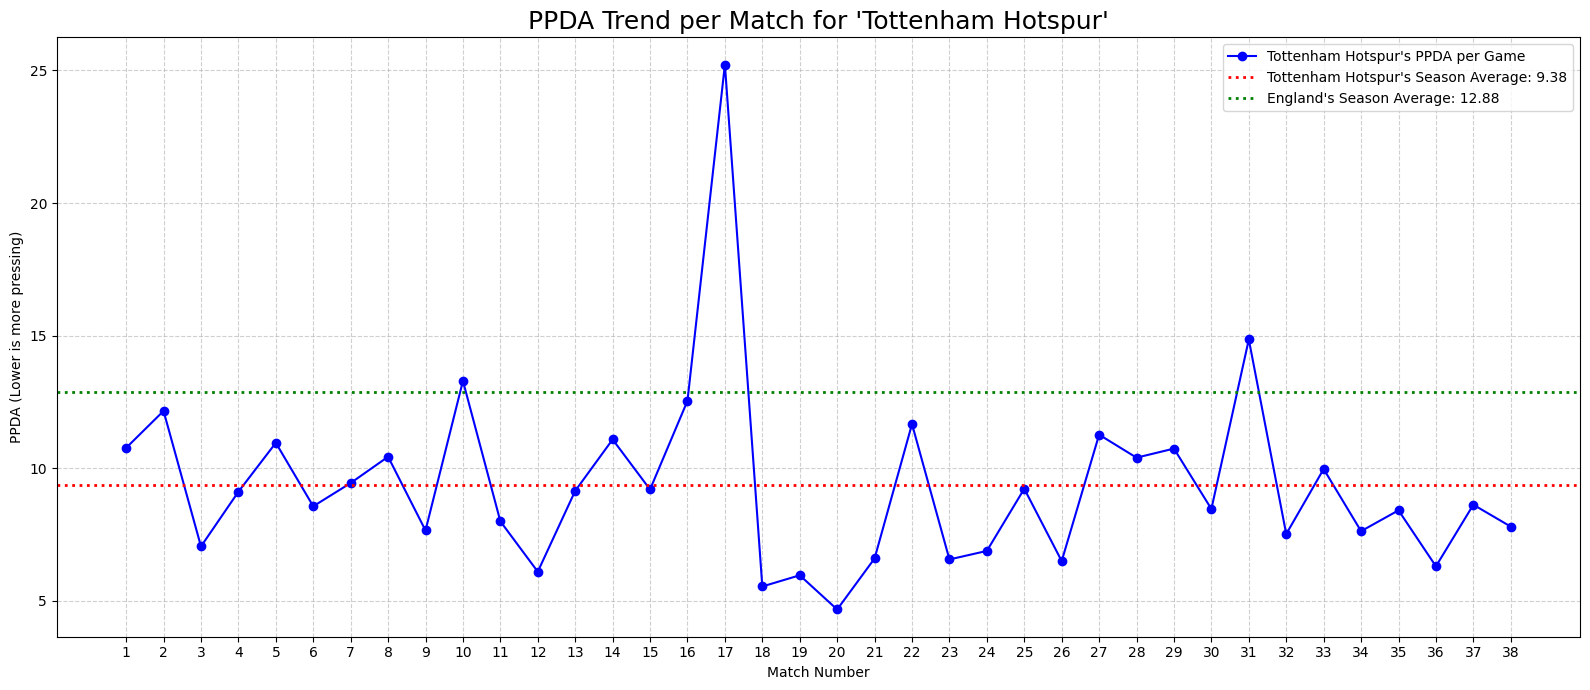

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

team_season_ppda = ppda_df[ppda_df['team_name'] == team]['ppda'].dropna()
league_ppda_avg = ppda_df['ppda'].mean()

x_axis = range(1, len(team_season_ppda) + 1)

mean_ppda = team_season_ppda.mean()

plt.figure(figsize=(16, 7))

plt.plot(x_axis, team_season_ppda, marker='o', linestyle='-', color='blue', label=f'{team}\'s PPDA per Game')

plt.axhline(y=mean_ppda, color='red', linestyle=':', linewidth=2, label=f'{team}\'s Season Average: {mean_ppda:.2f}')
plt.axhline(y=league_ppda_avg, color='green', linestyle=':', linewidth=2, label=f'{league}\'s Season Average: {league_ppda_avg:.2f}')

plt.title(f"PPDA Trend per Match for '{team}'", fontsize=18)
plt.xlabel("Match Number")
plt.ylabel("PPDA (Lower is more pressing)")
plt.xticks(x_axis)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.show()

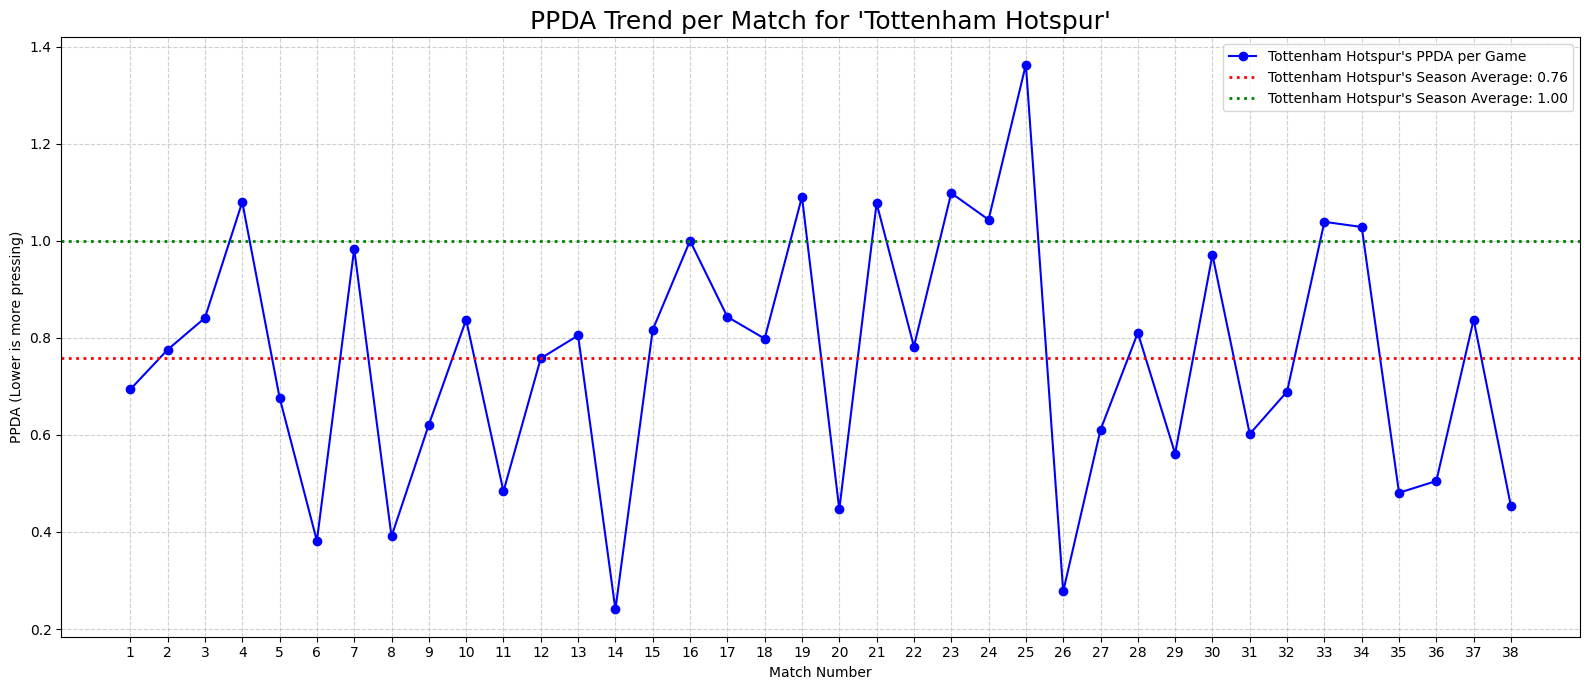

In [10]:
team_season_adj_ppda = adj_ppda_df[adj_ppda_df['team_name'] == team]['adj_ppda'].dropna()
league_adf_ppda_avg = adj_ppda_df['adj_ppda'].mean()

x_axis = range(1, len(team_season_adj_ppda) + 1)

mean_ppda = team_season_adj_ppda.mean()

plt.figure(figsize=(16, 7))

plt.plot(x_axis, team_season_adj_ppda, marker='o', linestyle='-', color='blue', label=f'{team}\'s PPDA per Game')

plt.axhline(y=mean_ppda, color='red', linestyle=':', linewidth=2, label=f'{team}\'s Season Average: {mean_ppda:.2f}')
plt.axhline(y=league_adf_ppda_avg, color='green', linestyle=':', linewidth=2, label=f'{team}\'s Season Average: {league_adf_ppda_avg:.2f}')

plt.title(f"PPDA Trend per Match for '{team}'", fontsize=18)
plt.xlabel("Match Number")
plt.ylabel("PPDA (Lower is more pressing)")
plt.xticks(x_axis)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

plt.show()

In [11]:
gamestate_ppda_values = {
	'winning': [],
	'drawing': [],
	'losing': []
}

for match_file in all_match_files:
	match_file_path = os.path.join(matches_dir, match_file)
	match_events = pd.read_pickle(match_file_path)

	if team in match_events['team_name'].unique():

		team_id = match_events[match_events['team_name'] == team]['team_id'].iloc[0]

		# 상황 정보 추가
		match_with_gamestate = add_gamestate_to_match(match_events, team_id)

		# 각 상황별로 PPDA 계산
		for state in ['winning', 'drawing', 'losing']:
			state_events = match_with_gamestate[match_with_gamestate['game_state'] == state]

			if state_events['team_id'].nunique() >= 2:
				ppda_in_state = calculate_match_ppda(state_events)

				# 분석 대상 팀의 PPDA 값만 추가
				if team_id in ppda_in_state:
					gamestate_ppda_values[state].append(ppda_in_state[team_id])

# 최종 상황별 평균 PPDA 계산
final_gamestate_ppda = {}
for state, ppda_list in gamestate_ppda_values.items():
	final_gamestate_ppda[state] = np.nanmean(ppda_list) if ppda_list else np.nan

# 결과 출력
print(f"{team} 상황별 시즌 PPDA")
for state, ppda in final_gamestate_ppda.items():
	print(f"  - {state.capitalize()} 상황: {ppda:.2f}")

Tottenham Hotspur 상황별 시즌 PPDA
  - Winning 상황: 10.60
  - Drawing 상황: 9.00
  - Losing 상황: 7.79


In [13]:
gamestate_std_ppda_values = {
	'winning': [],
	'drawing': [],
	'losing': []
}

# 모든 경기 파일을 순회하며 분석
for match_file in all_match_files:
	match_file_path = os.path.join(matches_dir, match_file)
	match_events = pd.read_pickle(match_file_path)

	if team in match_events['team_name'].unique():

		overall_ppda = calculate_match_ppda(match_events)

		match_avg_ppda = np.nanmean(list(overall_ppda.values()))

		team_id = match_events[match_events['team_name'] == team]['team_id'].iloc[0]
		match_with_gamestate = add_gamestate_to_match(match_events, team_id)

		for state in ['winning', 'drawing', 'losing']:
			state_events = match_with_gamestate[match_with_gamestate['game_state'] == state]

			if state_events['team_id'].nunique() >= 2:
				ppda_in_state_dict = calculate_match_ppda(state_events)

				if team_id in ppda_in_state_dict:
					raw_ppda_in_state = ppda_in_state_dict[team_id]

					standardized_ppda = raw_ppda_in_state / match_avg_ppda
					gamestate_std_ppda_values[state].append(standardized_ppda)

# 최종 상황별 표준화된 평균 PPDA 계산
final_gamestate_std_ppda = {}
for state, ppda_list in gamestate_std_ppda_values.items():
	final_gamestate_std_ppda[state] = np.nanmean(ppda_list) if ppda_list else np.nan

# 결과 출력
print(f"{team}의 표준화된 경기 상황별 시즌 PPDA")
for state, ppda in final_gamestate_std_ppda.items():
	print(f"  - {state.capitalize()} 상황: {ppda:.2f}")

Tottenham Hotspur의 표준화된 경기 상황별 시즌 PPDA
  - Winning 상황: 0.79
  - Drawing 상황: 0.76
  - Losing 상황: 0.73
